In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
import re
import cv2
from tqdm.notebook import trange, tqdm

from shutil import copyfile
os.add_dll_directory(r'C:\Users\thu71\Downloads\openslide-win64-20171122\bin')
import openslide
from PIL import Image
import tifffile
Image.MAX_IMAGE_PIXELS = None

from skimage.transform import resize, rescale
from skimage import img_as_ubyte, measure
import scipy.ndimage as ndimage
import pickle

In [2]:
cwd = Path(r'Y:\coskun-lab\Manali cases TNBC-immune')


# Extract annotation cancer region

In [7]:
def create_mask_annotation(img):
    '''
    Create mask from pathologist annotation 
    '''
    hsv_origimg = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_origimg, np.array([40, 125, 30]), np.array([70, 255, 255]))

    return mask

nonresponder_240584.ome.tif


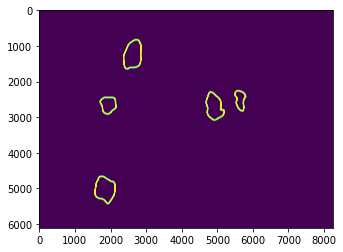

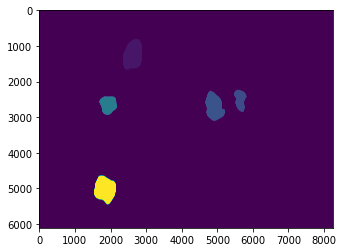

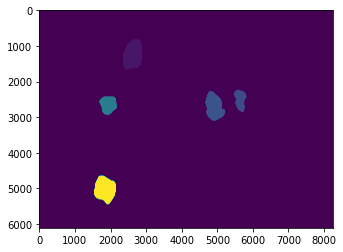

Number of region: 5
369029
148012
317506
195115
361352
nonresponder_240585.ome.tif


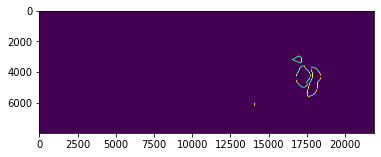

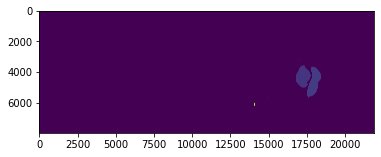

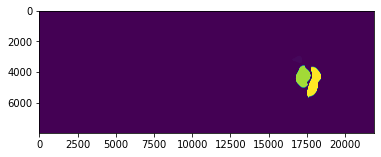

Number of region: 3
204604
977271
1051876
nonresponder_240607.ome.tif


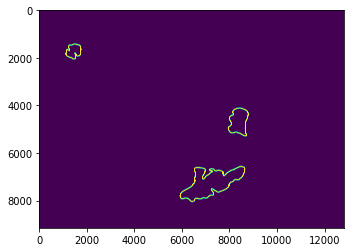

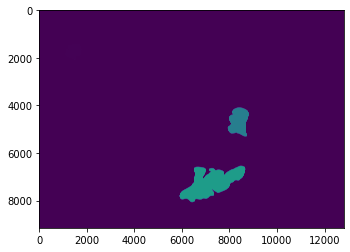

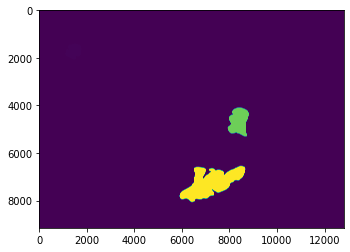

Number of region: 3
341155
768616
2177326
responder_240586.ome.tif


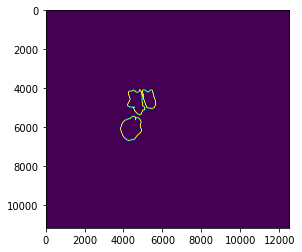

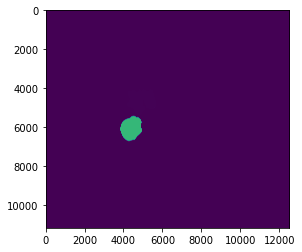

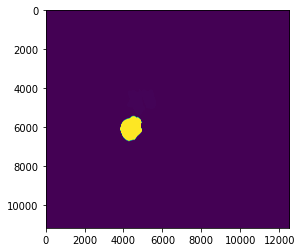

Number of region: 2
1346734
1055889
responder_240587.ome.tif


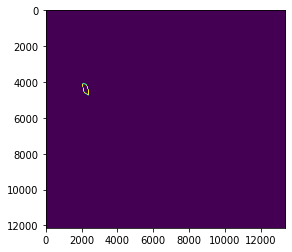

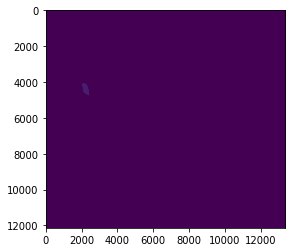

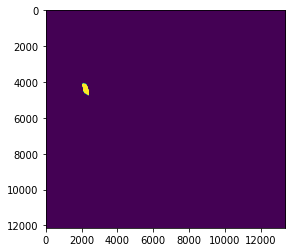

Number of region: 1
173815
responder_240608.ome.tif


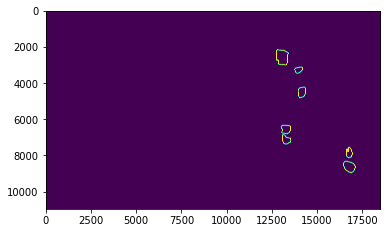

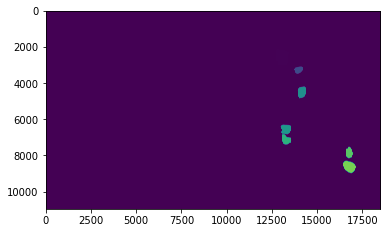

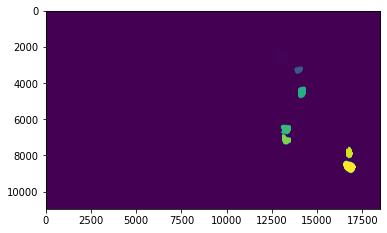

Number of region: 7
522810
140625
234601
244663
205522
182238
340980
Thumbs.db


In [20]:
from skimage import morphology

for (dirpath, dirnames, filenames) in os.walk(cwd / 'annotated'):
    for name in filenames:
        print(name)
        if 'tif' not in name:
            continue
            
        # Read and rescale image
        path = os.path.join(dirpath, name)
        img = skimage.io.imread(path)
        # img_rescaled = resize(img, (int(img.shape[0]/10), int(img.shape[1]/10), 3))
        img_rescaled = img_as_ubyte(img)
        
        # Extract green annotation region
        mask = create_mask_annotation(img_rescaled)
        plt.imshow(mask)
        plt.show()
        
        masked_filled = ndimage.binary_fill_holes(mask)
        masked_filled, _ = ndimage.label(masked_filled)
        plt.imshow(masked_filled)
        plt.show()
        
        masked_filled = morphology.remove_small_objects(masked_filled, 25000)
        plt.imshow(masked_filled)
        plt.show()
        
        # Get annotation region bbox and mask
        info = []
        props = measure.regionprops(masked_filled.astype(np.uint8))
        print(f'Number of region: {len(props)}')
        for prop in props:
            print(prop['area'])
            info_dict = {'mask': prop['image'],
                        'bbox': prop['bbox']}
            info.append(info_dict)
        
        file = name.split('.')[0].split('_')[1]
        with open(cwd / 'masks' / f'{file}.pickle', 'wb') as handle:
            pickle.dump(info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
for (dirpath, dirnames, filenames) in os.walk(cwd / 'subset'):
    for name in filenames:
        print(name)
        path = os.path.join(dirpath, name)
        
        # Read region info
        file = name.split('.')[0]
        pickle_path = cwd / 'masks' / f'{file}.pickle'
        if not os.path.exists(pickle_path):
            continue
        else:
            with open(pickle_path, 'rb') as handle:
                info = pickle.load(handle)
        
        # Get WSI
        wsi = openslide.open_slide(path)

        # Get bbox
        for i, info_dict in enumerate(info):
            min_row, min_col, max_row, max_col = info_dict['bbox']
            min_row *= 7
            min_col *= 7
            max_row *= 7
            max_col *= 7
            
            mask = info_dict['mask']
            mask_rescaled = rescale(mask, 7)
            mask_rescaled = img_as_ubyte(mask_rescaled)

            img = np.asarray(wsi.read_region((min_col, min_row), 0, (max_col - min_col, max_row - min_row)).convert("RGB"))

            dest = cwd / 'cropped' / f'{file}_{i}.tiff'
            tifffile.imwrite(dest, img, bigtiff=True)           
            
            dest = cwd / 'masks' / f'{file}_{i}.tiff'
            tifffile.imwrite(dest, mask_rescaled, bigtiff=True)  

240584.svs
240585.svs
240586.svs
240587.svs
240607.svs
240608.svs
